In [135]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import faiss

sns.set_style(style="whitegrid")

In [252]:
TICKER = "SPY"
START_DATE = "2000-01-01"
END_DATE = "2024-01-01"
LOOKBACK_WINDOW = 60
FORECAST_HORIZON = 5


def get_features(df: pd.DataFrame, window: int = 20) -> pd.DataFrame:
    """Generate features for the financial data DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame with financial data.
        window (int, optional): The rolling window size for volatility calculation. Defaults to 20.
    Returns:
        pd.DataFrame: The DataFrame with additional features.
    """
    df = df[["Close", "Volume"]].copy()

    df["Log_Ret"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Volatility"] = df["Log_Ret"].rolling(window=window).std()
    df["Log_Vol_Chg"] = np.log((df["Volume"] + 1e-9) / (df["Volume"].shift(1) + 1e-9))

    df.dropna(inplace=True)
    return df


def get_financial_data(ticker: str, start: str, end: str) -> pd.DataFrame:
    """Fetch historical financial data for a specific ticker.

    Args:
        ticker (str): The stock ticker symbol.
        start (str): The start date for the data (YYYY-MM-DD).
        end (str): The end date for the data (YYYY-MM-DD).

    Returns:
        pd.DataFrame: A DataFrame containing the historical financial data.
    """

    print(f"Stock: {ticker}")
    df = yf.download(ticker, start=start, end=end, auto_adjust=True)
    
    return df


df = get_financial_data(TICKER, START_DATE, END_DATE)
df = get_features(df)
df[:10]

[*********************100%***********************]  1 of 1 completed

Stock: SPY


Price,Close,Volume,Log_Ret,Volatility,Log_Vol_Chg
Ticker,SPY,SPY,,,
Date,,,,,
2000-02-01,89.044632,8419900,0.009804,0.021565,-0.246046
2000-02-02,89.123650,6205900,0.000887,0.019588,-0.305097
2000-02-03,90.466225,7997500,0.014952,0.019854,0.253629
2000-02-04,90.091064,4925400,-0.004156,0.019480,-0.484724
2000-02-07,89.952881,5845800,-0.001535,0.014614,0.171318
2000-02-08,91.176994,4936400,0.013517,0.014951,-0.169087
2000-02-09,89.261810,8511500,-0.021229,0.015452,0.544782
2000-02-10,89.439537,6690600,0.001989,0.015322,-0.240715


<Axes: title={'center': 'SPY Closing Prices'}, xlabel='Date'>

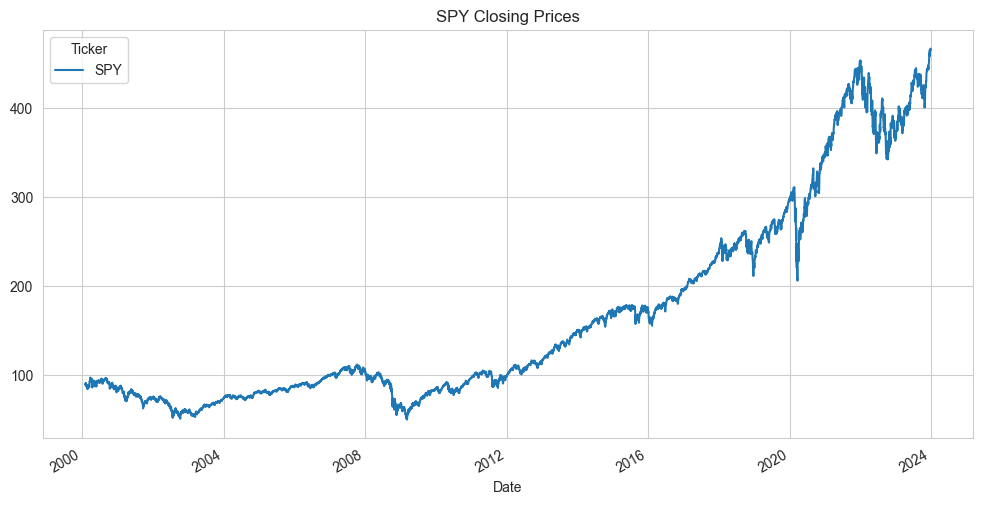

In [254]:
df["Close"].plot(title=f"{TICKER} Closing Prices", figsize=(12, 6))

array([[<Axes: title={'center': "('Close', 'SPY')"}>,
        <Axes: title={'center': "('Volume', 'SPY')"}>],
       [<Axes: title={'center': "('Log_Ret', '')"}>,
        <Axes: title={'center': "('Volatility', '')"}>],
       [<Axes: title={'center': "('Log_Vol_Chg', '')"}>, <Axes: >]],
      dtype=object)

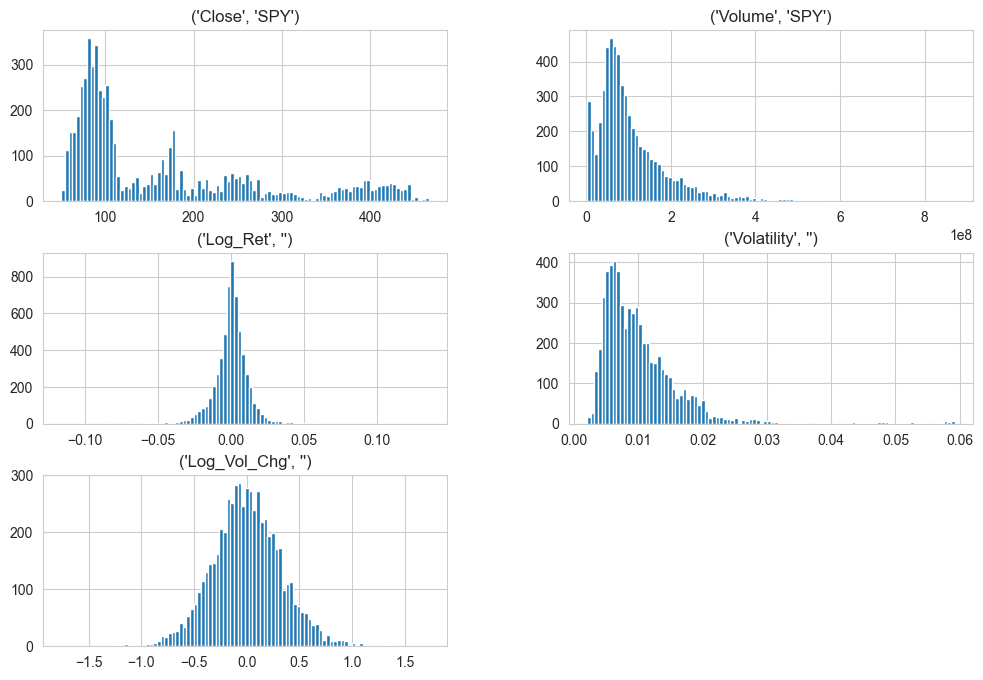

In [253]:
df.hist(bins=100, figsize=(12, 8))

In [116]:
def create_sequences(data:pd.DataFrame, lookback: int, horizon: int) -> tuple[np.ndarray, np.ndarray]:
    """Create sequences of data for time series forecasting.

    Args:
        data (pd.DataFrame): The input data containing features.
        lookback (int): The number of past timesteps to include in each input sequence.
        horizon (int): The number of future timesteps to predict.

    Returns:
        Tuple[np.ndarray, np.ndarray]: The input sequences (X) and the corresponding targets (y).
    """
    X, y = [], []

    feature_cols = ['Log_Ret', 'Volatility', 'Log_Vol_Chg']
    data_values = data[feature_cols].values

    for i in range(len(data) - lookback - horizon):
        window = data_values[i : i + lookback]
        future_window = data_values[i + lookback : i + lookback + horizon, 0]

        X.append(window)
        y.append(future_window)

    
    return np.array(X), np.array(y)

X_raw, y_raw = create_sequences(df, LOOKBACK_WINDOW, FORECAST_HORIZON)

print(f"Created {X_raw.shape[0]} sequences.")
print(f"X shape: {X_raw.shape}  (Samples, Timesteps, Features)")
print(f"y shape: {y_raw.shape}  (Samples, Horizon)")

Created 5952 sequences.
X shape: (5952, 60, 3)  (Samples, Timesteps, Features)
y shape: (5952, 5)  (Samples, Horizon)


$$x_t' = \frac{x_t - \mu_{window}}{\sigma_{window} + \epsilon}$$

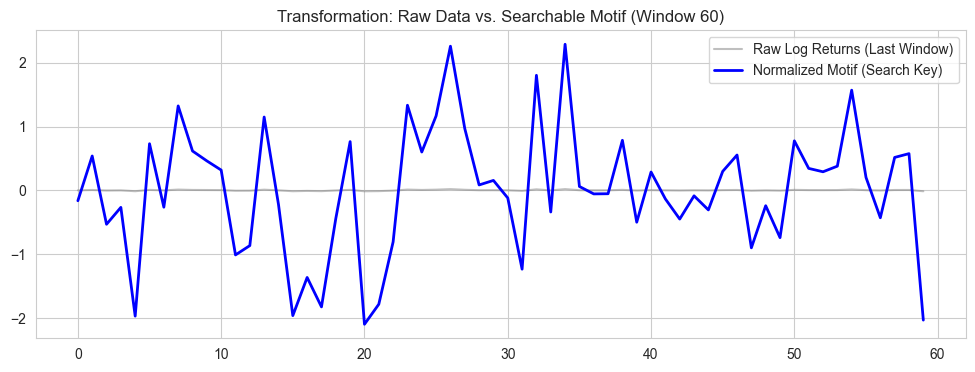

In [130]:
def normalize_windows(X: np.ndarray):
    """Normalize the input windows using Z-score normalization.

    Args:
        X (np.ndarray): The input data windows.

    Returns:
        tuple: A tuple containing the normalized windows, means, and standard deviations.
    """
    # Calculate Mean and Std along the time axis (axis 1)
    # keepdims=True ensures shapes broadcast correctly: (N, 1, F)
    means: np.float64 = np.mean(X, axis=1, keepdims=True)
    stds: np.float64 = np.std(X, axis=1, keepdims=True)

    # Division by zero with a small epsilon
    epsilon = 1e-8

    X_norm = (X - means) / (stds + epsilon)

    return X_norm, means, stds


X_norm, X_means, X_stds = normalize_windows(X_raw)

# Verification Plot
plt.figure(figsize=(12, 4))
plt.plot(
    X_raw[-1, :, 0], label="Raw Log Returns (Last Window)", color="gray", alpha=0.5
)
plt.plot(
    X_norm[-1, :, 0], label="Normalized Motif (Search Key)", color="blue", linewidth=2
)
plt.title(f"Transformation: Raw Data vs. Searchable Motif (Window {LOOKBACK_WINDOW})")
plt.legend()
plt.show()

In [161]:
N, T, F = X_norm.shape
d = F * T

print(f"N (Samples): {N}, T (Timesteps): {T}, F (Features): {F}")
print(f"d (Dimension): {d}")

# Float32 for Faiss
X_flat = X_norm.reshape(N, d).astype('float32')
print(f"X_flat shape: {X_flat.shape}")

index = faiss.IndexFlatL2(d) 
index.add(X_flat)

print(f"Number of vectors in the index: {index.ntotal}")
print(f"Training status: {index.is_trained}")

N (Samples): 5952, T (Timesteps): 60, F (Features): 3
d (Dimension): 180
X_flat shape: (5952, 180)
Number of vectors in the index: 5952
Training status: True


In [263]:
faiss.write_index(index, "../Data/FAISS/financial_data_index.faiss")

In [258]:
q_id = 100
query_vector = X_flat[q_id].reshape(1, -1)
print(query_vector.shape)
query_vector[0,:3]

(1, 180)


array([-0.9472322,  1.6330793, -0.9511445], dtype=float32)

In [256]:
query_vector

array([[ 6.4529157e-01, -5.1442242e-01,  5.8494532e-01, -8.3508348e-01,
        -4.8505023e-01, -5.1663017e-01, -2.8717539e-01, -5.7479918e-01,
        -3.5531968e-01, -1.2245519e+00, -3.7486154e-01,  4.8099986e-01,
        -1.3736446e-01, -7.6376253e-01,  1.2527139e+00,  6.7311066e-01,
        -7.5663966e-01, -6.9400030e-01, -1.1473562e+00, -5.8535600e-01,
         8.0841213e-01, -1.9880968e-01, -5.8590269e-01, -1.1343386e+00,
         1.1849610e+00, -8.4688830e-01,  5.3171968e-01,  5.5147469e-01,
        -1.2465498e+00, -1.1067629e+00,  4.1829923e-01, -1.2780460e+00,
        -4.2006171e-01,  4.5412555e-02, -1.2785120e+00,  2.2221777e-01,
         1.0595577e+00, -1.1957167e+00,  1.1676348e+00, -5.4861349e-01,
        -1.1512748e+00, -1.5414758e-01, -1.1013324e+00, -9.4606280e-01,
         1.1624707e+00, -6.4254373e-02, -1.1012383e+00, -1.2068653e+00,
         1.6414465e+00, -7.8282481e-01, -1.7363402e+00, -2.9592872e-01,
        -7.7111310e-01,  8.1928277e-01, -6.1650765e-01, -9.49186

In [259]:
k = 5
distances, indices = index.search(query_vector, k)

print("\n--- Retrieval Results ---")
print(f"Query Index: {q_id}")
print(f"Found Match Indices: {indices[0]}")
print(f"Similarity Scores (L2 Dist): {distances[0]}")


--- Retrieval Results ---
Query Index: 100
Found Match Indices: [ 100 1419 2639 4928 1606]
Similarity Scores (L2 Dist): [  0.      198.96664 202.28888 203.25925 203.9369 ]


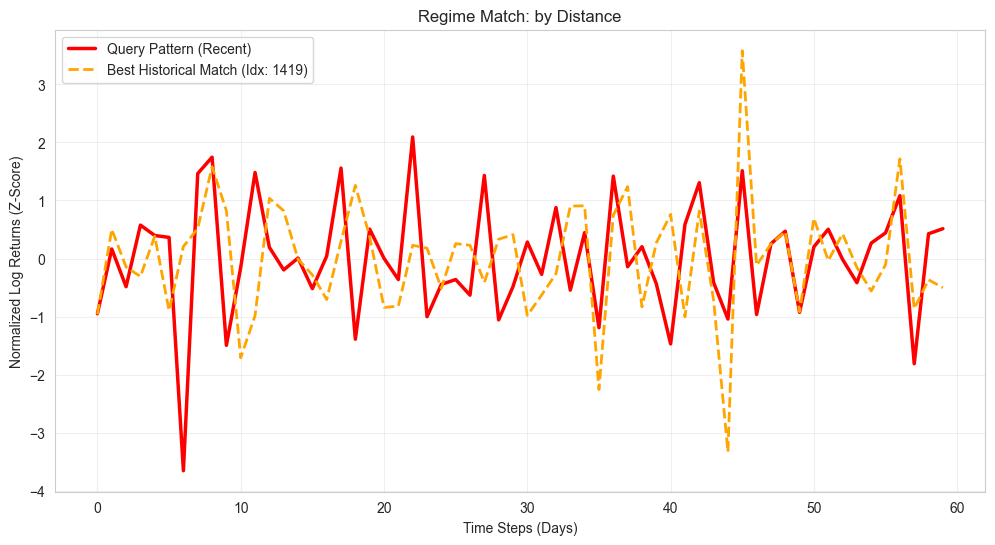

In [262]:
f = 2
plt.figure(figsize=(12, 6))
plt.plot(X_norm[q_id,:,f], label='Query Pattern (Recent)', color='red', linewidth=2.5)

plt.plot(X_norm[indices[0][1], :, f], label=f'Best Historical Match (Idx: {indices[0][1]})', 
         color='orange', linestyle='--', linewidth=2)


# plt.plot(X_norm[indices[0][2], :, 0], label=f'2nd Best Historical Match (Idx: {indices[0][2]})', 
#          color='gray', linestyle='--', linewidth=2)
plt.title(f"Regime Match: by Distance")
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylabel("Normalized Log Returns (Z-Score)")
plt.xlabel("Time Steps (Days)")
plt.show()